In [1]:
from tpe.optimizer import TPEOptimizer
import numpy as np
import matplotlib.pyplot as plt
import os
from tpe.utils.benchmarks import (
    Ackley,
    DifferentPower,
    Griewank,
    Perm,
    KTablet,
    Levy,
    Rastrigin,
    Rosenbrock,
    Schwefel,
    Sphere,
    Styblinski,
    WeightedSphere,
    XinSheYang,
)
from tpe.utils.constants import WeightFuncs

os.makedirs("figs/", exist_ok=True)

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.rcParams['mathtext.fontset'] = 'stix'  # The setting of math font

start K-Tablet
start Ackley
start Perm
start Griewank
start Sphere
start Levy
start Weighted sphere
start Schwefel


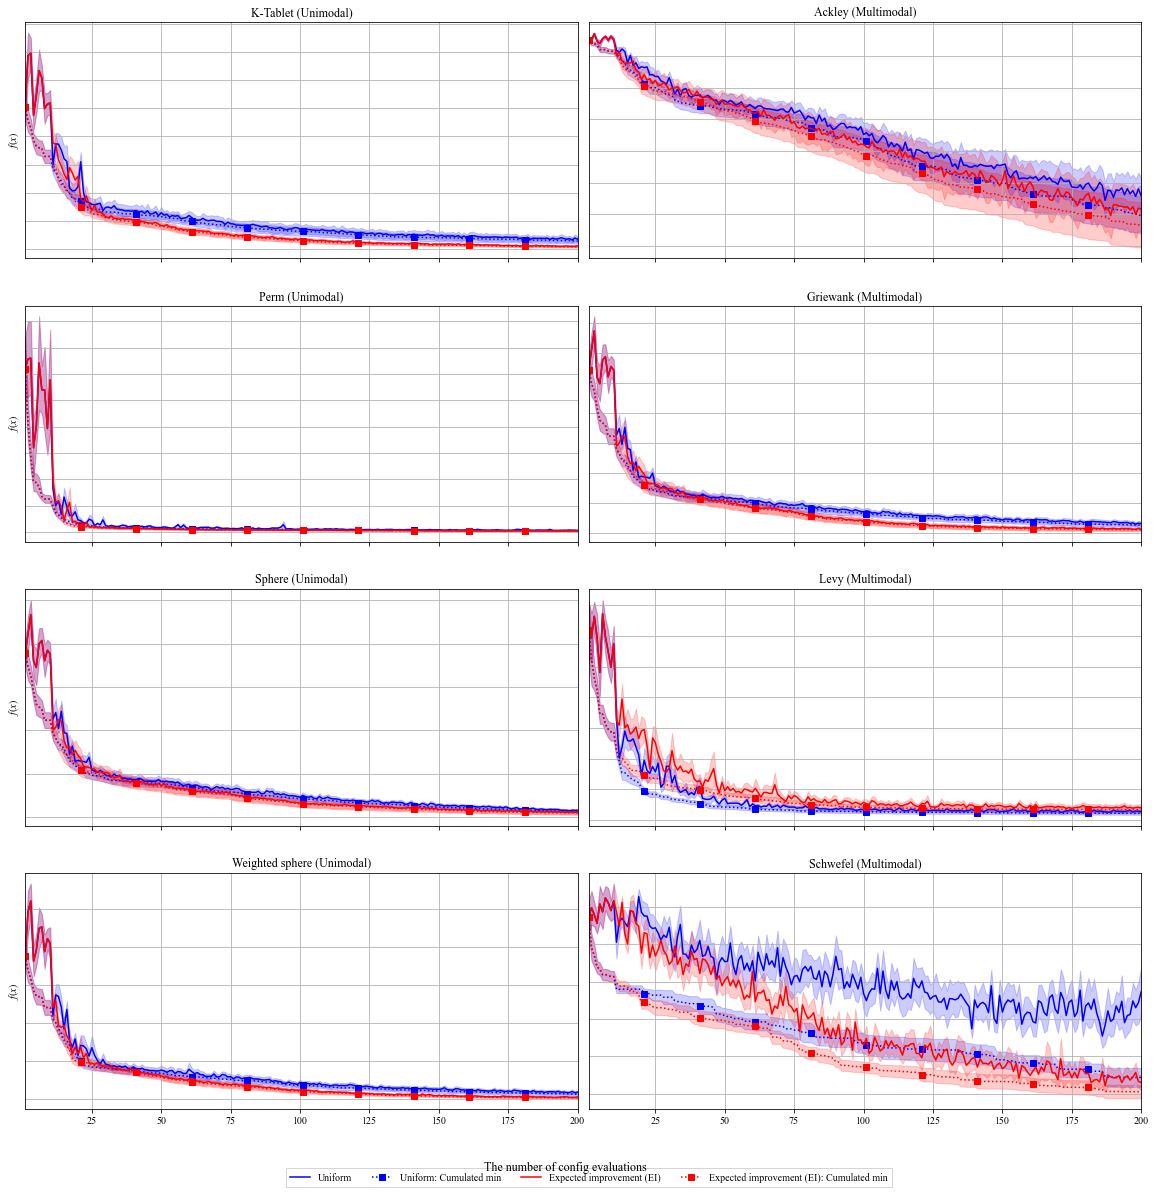

In [2]:
from typing import Dict
from tpe.utils.constants import WeightFuncs, QuantileFunc
import ConfigSpace as CS

n_seeds = 10
DIM = 10
max_evals = 200


def plot(ax: plt.Axes, func):
    config_space = CS.ConfigurationSpace()

    for d in range(DIM):
        config = CS.UniformFloatHyperparameter(f"x{d}", -1, 1)
        config_space.add_hyperparameter(config)

    results = {}
    means = {}
    stes = {}
    cum_means = {}
    cum_stes = {}
    # weight_func_choices = ["uniform", "older-smaller", "expected-improvement"]
    weight_func_choices = ["uniform", "expected-improvement"]
    name_dict = {"uniform": "Uniform", "older-smaller": "Recency decay", "expected-improvement": "Expected improvement (EI)"}
    for weight_func_choice in weight_func_choices:
        results[weight_func_choice] = np.zeros((n_seeds, max_evals))
        for seed in range(n_seeds):
            opt = TPEOptimizer(
                obj_func=func,
                config_space=config_space,
                # quantile_func=QuantileFunc(choice="sqrt", alpha=0.25),
                quantile_func=QuantileFunc(choice="linear", alpha=0.15),
                max_evals=max_evals,
                min_bandwidth_factor=1e-2,
                weight_func_choice=weight_func_choice,
                seed=seed,
            )
            opt.optimize()
            loss_vals = opt.fetch_observations()["loss"]
            results[weight_func_choice][seed] += loss_vals
        else:
            cum_loss_vals = np.minimum.accumulate(results[weight_func_choice], axis=-1)
            cum_means[weight_func_choice] = np.mean(cum_loss_vals, axis=0)
            cum_stes[weight_func_choice] = np.std(cum_loss_vals, axis=0) / np.sqrt(n_seeds)
            means[weight_func_choice] = np.mean(results[weight_func_choice], axis=0)
            stes[weight_func_choice] = np.std(results[weight_func_choice], axis=0) / np.sqrt(n_seeds)

    X = np.arange(max_evals) + 1
    colors = ["blue", "red"]
    lines, labels = [], []
    for color, weight_func_choice in zip(colors, weight_func_choices):
        m = means[weight_func_choice]
        s = stes[weight_func_choice]
        cm = cum_means[weight_func_choice]
        cs = cum_stes[weight_func_choice]
        line, = ax.plot(X, m, color=color)
        lines.append(line)
        labels.append(f"{name_dict[weight_func_choice]}")
        ax.fill_between(X, m - s, m + s, color=color, alpha=0.2)

        line, = ax.plot(X, cm, color=color, marker="s", markevery=max_evals//10, linestyle="dotted")
        lines.append(line)
        labels.append(f"{name_dict[weight_func_choice]}: Cumulated min")
        ax.fill_between(X, cm - cs, cm + cs, color=color, alpha=0.2)

    ax.grid()
    ax.set_xlim(1, max_evals)
    return lines, labels


def start():
    fig, axes = plt.subplots(
        figsize=(20, 20),
        ncols=2,
        nrows=4,
        gridspec_kw=dict(
            wspace=0.02,
        ),
        sharex=True,
    )
    TICK_PARAMS = dict(labelleft=False, left=False)

    for ax_in_row, fc_in_row in zip(axes, [
        (KTablet, Ackley),
        (Perm, Griewank),
        (Sphere, Levy),
        (WeightedSphere, Schwefel),
    ]):
        ax, fc = ax_in_row[0], fc_in_row[0]
        print(f"start {fc.name}")
        ax.tick_params(**TICK_PARAMS)
        plot(ax, func=fc.func)
        ax.set_title(f"{fc.name} (Unimodal)")
        ax.set_ylabel("$f(x)$")

        ax, fc = ax_in_row[1], fc_in_row[1]
        print(f"start {fc.name}")
        ax.tick_params(**TICK_PARAMS)
        lines, labels = plot(ax, func=fc.func)
        ax.set_title(f"{fc.name} (Multimodal)")
    else:
        ax = axes[-1][1]
        ax.legend(
            handles=lines,
            labels=labels,
            ncols=len(labels),
            loc="upper center",
            bbox_to_anchor=(0.0, -0.23),
            fancybox=False,
            shadow=False,
        )

    ax = axes[0]
    fig.supxlabel("The number of config evaluations", y=0.08)
    plt.savefig("figs/weight-strategy-comparison.pdf", bbox_inches="tight")


start()

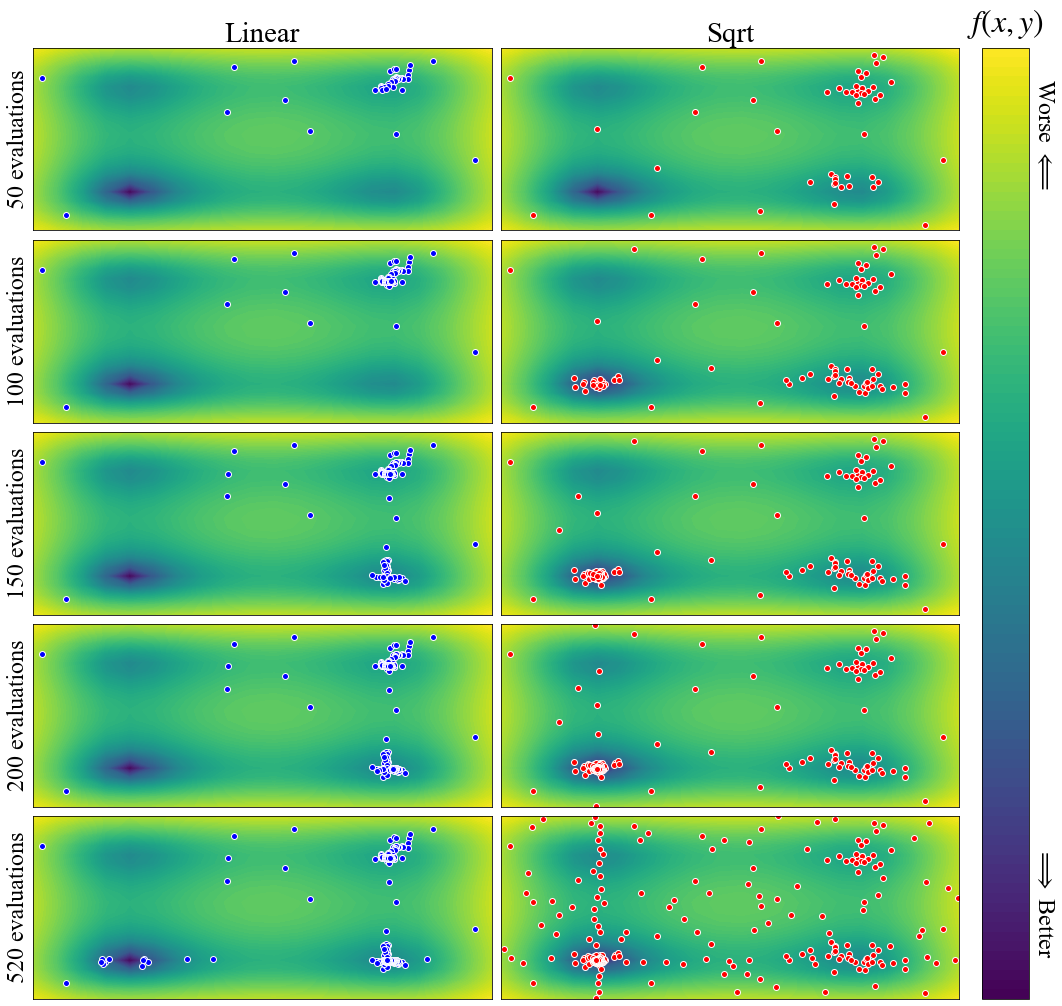

In [14]:
target = Styblinski
X, Y = np.meshgrid(np.linspace(-1, 1, 20), np.linspace(-1, 1, 20))
Z = target.func2d(X, Y)
Z -= Z.min() - 1
Z = np.log(Z)
R = 5
n_levels = 100
levels = np.linspace(Z.min(), Z.max(), n_levels)

max_evals = 520


def add_colorbar(fig, cb, axes):
    cbar = fig.colorbar(cb, ax=axes.ravel().tolist(), pad=0.02)
    cbar.ax.set_title("$f(x, y)$", y=1.01, fontsize=32)
    labels = [""] * n_levels
    labels[-10], labels[10] = "Worse $\Longleftarrow$", "$\Longrightarrow$ Better"
    cbar.set_ticks(levels)
    cbar.set_ticklabels(labels, fontsize=24)
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=270, va="center")
    # tick目盛りを削除
    cbar.ax.tick_params(size=0)
    return cb


def plot_func(ax):
    ax.tick_params(labelbottom=False, bottom=False, labelleft=False, left=False)
    cb = ax.contourf(X * R, Y * R, Z, levels=levels)
    return cb

nrows = 5
fig, axes = plt.subplots(
    ncols=2,
    nrows=nrows,
    figsize=(20, 3.5 * nrows),
    gridspec_kw=dict(
        wspace=0.02,
        hspace=0.05
    )
)
config_space = CS.ConfigurationSpace()
config_space.add_hyperparameter(CS.UniformFloatHyperparameter("x", -1, 1))
config_space.add_hyperparameter(CS.UniformFloatHyperparameter("y", -1, 1))
opt_uniform = TPEOptimizer(
    obj_func=target.func,
    config_space=config_space,
    quantile_func=QuantileFunc(choice="sqrt", alpha=0.25),
    max_evals=max_evals,
    min_bandwidth_factor=1e-2,
    weight_func_choice="uniform",
    seed=0,
)
opt_uniform.optimize()
opt_decay = TPEOptimizer(
    obj_func=target.func,
    config_space=config_space,
    quantile_func=QuantileFunc(choice="sqrt", alpha=0.25),
    max_evals=max_evals,
    min_bandwidth_factor=1e-2,
    weight_func_choice="older-smaller",
    seed=0,
)
opt_decay.optimize()

for r in range(nrows):
    n_evals = 50 * (r + 1) if r != nrows - 1 else max_evals
    ax = axes[r][0]
    if r == 0:
        ax.set_title("Uniform")

    plot_func(ax)
    results_linear = opt_linear.fetch_observations()
    ax.scatter(results_linear["x"][:n_evals] * R, results_linear["y"][:n_evals] * R, color="blue", ec="white")
    ax.set_ylabel(f"{n_evals} evaluations")

    ax = axes[r][1]
    if r == 0:
        ax.set_title("Recency decay")
    cb = plot_func(ax)
    results_sqrt = opt_sqrt.fetch_observations()
    ax.scatter(results_sqrt["x"][:n_evals] * R, results_sqrt["y"][:n_evals] * R, color="red", ec="white")
else:
    add_colorbar(fig, cb, axes)

plt.savefig("figs/exploration-by-weight-in-styblinski.pdf", bbox_inches="tight")

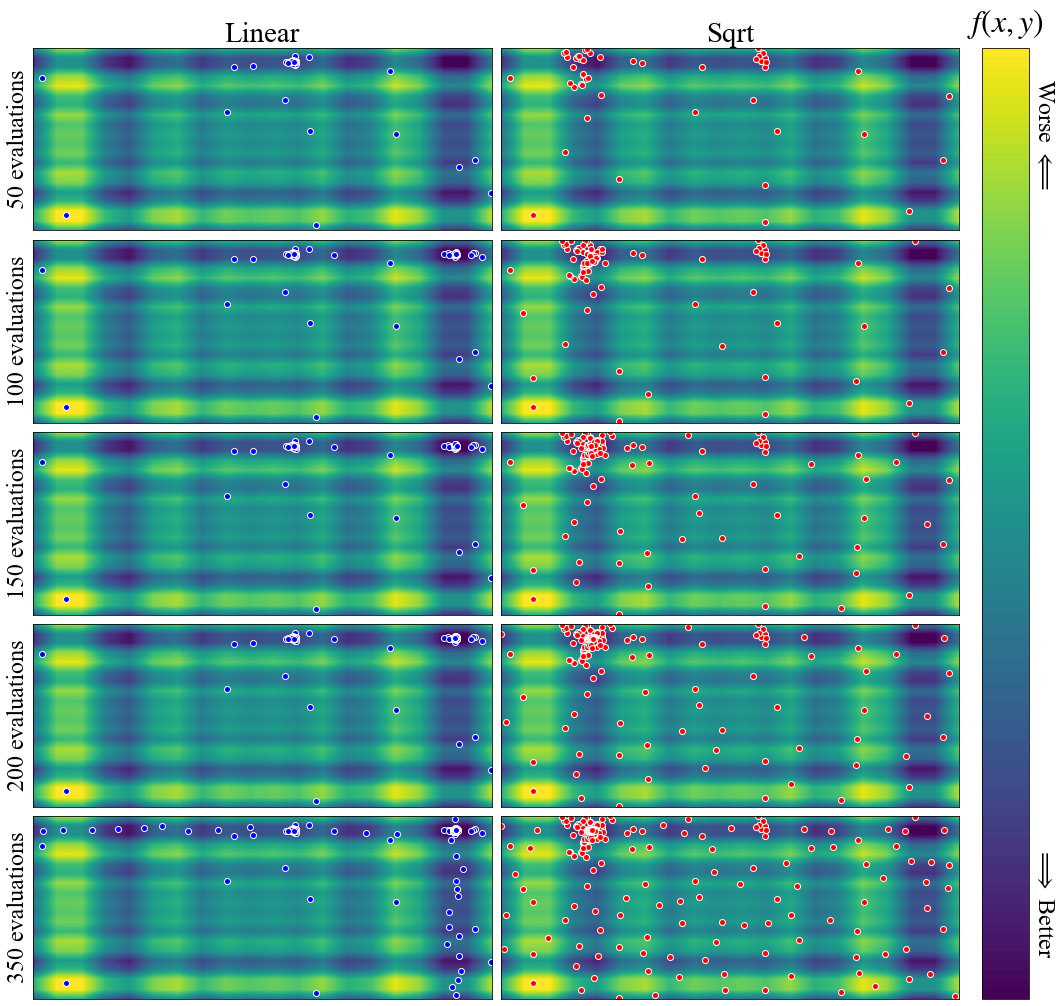

In [15]:
target = Schwefel
X, Y = np.meshgrid(np.linspace(-1, 1, 20), np.linspace(-1, 1, 20))
Z = target.func2d(X, Y)
Z -= Z.min() - 1
# Z = np.log(Z)
R = 500
n_levels = 100
levels = np.linspace(Z.min(), Z.max(), n_levels)

max_evals = 350


def add_colorbar(fig, cb, axes):
    cbar = fig.colorbar(cb, ax=axes.ravel().tolist(), pad=0.02)
    cbar.ax.set_title("$f(x, y)$", y=1.01, fontsize=32)
    labels = [""] * n_levels
    labels[-10], labels[10] = "Worse $\Longleftarrow$", "$\Longrightarrow$ Better"
    cbar.set_ticks(levels)
    cbar.set_ticklabels(labels, fontsize=24)
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=270, va="center")
    # tick目盛りを削除
    cbar.ax.tick_params(size=0)
    return cb


def plot_func(ax):
    ax.tick_params(labelbottom=False, bottom=False, labelleft=False, left=False)
    cb = ax.contourf(X * R, Y * R, Z, levels=levels)
    return cb

nrows = 5
fig, axes = plt.subplots(
    ncols=2,
    nrows=nrows,
    figsize=(20, 3.5 * nrows),
    gridspec_kw=dict(
        wspace=0.02,
        hspace=0.05
    )
)
config_space = CS.ConfigurationSpace()
config_space.add_hyperparameter(CS.UniformFloatHyperparameter("x", -1, 1))
config_space.add_hyperparameter(CS.UniformFloatHyperparameter("y", -1, 1))
opt_sqrt = TPEOptimizer(
    obj_func=target.func,
    config_space=config_space,
    quantile_func=QuantileFunc(choice="sqrt", alpha=0.25),
    max_evals=max_evals,
    min_bandwidth_factor=1e-2,
    weight_func_choice="uniform",
    seed=0,
)
opt_sqrt.optimize()
opt_linear = TPEOptimizer(
    obj_func=target.func,
    config_space=config_space,
    quantile_func=QuantileFunc(choice="linear", alpha=0.15),
    max_evals=max_evals,
    min_bandwidth_factor=1e-2,
    weight_func_choice="uniform",
    seed=0,
)
opt_linear.optimize()

for r in range(nrows):
    n_evals = 50 * (r + 1) if r != nrows - 1 else max_evals
    ax = axes[r][0]
    if r == 0:
        ax.set_title("Linear")

    plot_func(ax)
    results_linear = opt_linear.fetch_observations()
    ax.scatter(results_linear["x"][:n_evals] * R, results_linear["y"][:n_evals] * R, color="blue", ec="white")
    ax.set_ylabel(f"{n_evals} evaluations")

    ax = axes[r][1]
    if r == 0:
        ax.set_title("Sqrt")
    cb = plot_func(ax)
    results_sqrt = opt_sqrt.fetch_observations()
    ax.scatter(results_sqrt["x"][:n_evals] * R, results_sqrt["y"][:n_evals] * R, color="red", ec="white")
else:
    add_colorbar(fig, cb, axes)

plt.savefig("figs/exploration-by-gamma-in-schwefel.pdf", bbox_inches="tight")

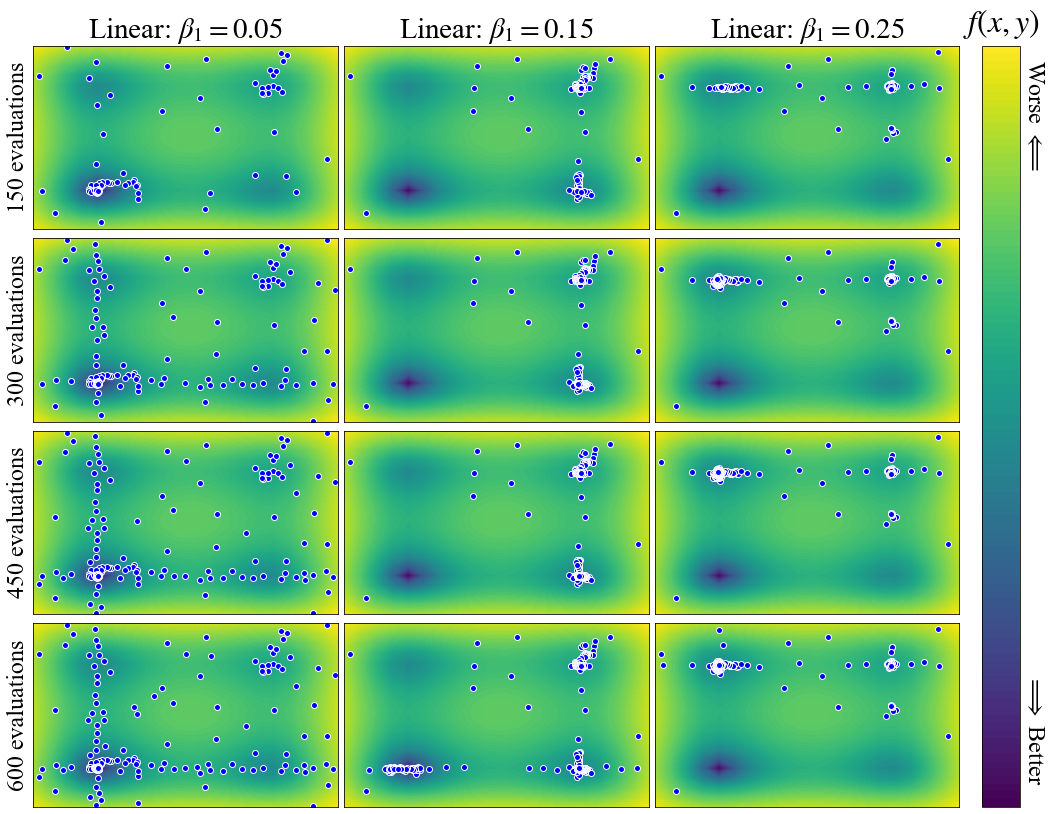

In [16]:
target = Styblinski
X, Y = np.meshgrid(np.linspace(-1, 1, 20), np.linspace(-1, 1, 20))
Z = target.func2d(X, Y)
Z -= Z.min() - 1
Z = np.log(Z)
R = 5
n_levels = 100
levels = np.linspace(Z.min(), Z.max(), n_levels)

max_evals = 600


def add_colorbar(fig, cb, axes):
    cbar = fig.colorbar(cb, ax=axes.ravel().tolist(), pad=0.02)
    cbar.ax.set_title("$f(x, y)$", y=1.01, fontsize=32)
    labels = [""] * n_levels
    labels[-10], labels[10] = "Worse $\Longleftarrow$", "$\Longrightarrow$ Better"
    cbar.set_ticks(levels)
    cbar.set_ticklabels(labels, fontsize=24)
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=270, va="center")
    # tick目盛りを削除
    cbar.ax.tick_params(size=0)
    return cb


def plot_func(ax):
    ax.tick_params(labelbottom=False, bottom=False, labelleft=False, left=False)
    cb = ax.contourf(X * R, Y * R, Z, levels=levels)
    return cb

nrows = 4
fig, axes = plt.subplots(
    ncols=3,
    nrows=nrows,
    figsize=(20, 3.5 * nrows),
    gridspec_kw=dict(
        wspace=0.02,
        hspace=0.05
    )
)
config_space = CS.ConfigurationSpace()
config_space.add_hyperparameter(CS.UniformFloatHyperparameter("x", -1, 1))
config_space.add_hyperparameter(CS.UniformFloatHyperparameter("y", -1, 1))
opt_05 = TPEOptimizer(
    obj_func=target.func,
    config_space=config_space,
    quantile_func=QuantileFunc(choice="linear", alpha=0.05),
    max_evals=max_evals,
    min_bandwidth_factor=1e-2,
    weight_func_choice="uniform",
    seed=0,
)
opt_05.optimize()

opt_15 = TPEOptimizer(
    obj_func=target.func,
    config_space=config_space,
    quantile_func=QuantileFunc(choice="linear", alpha=0.15),
    max_evals=max_evals,
    min_bandwidth_factor=1e-2,
    weight_func_choice="uniform",
    seed=0,
)
opt_15.optimize()
opt_25 = TPEOptimizer(
    obj_func=target.func,
    config_space=config_space,
    quantile_func=QuantileFunc(choice="linear", alpha=0.25),
    max_evals=max_evals,
    min_bandwidth_factor=1e-2,
    weight_func_choice="uniform",
    seed=0,
)
opt_25.optimize()

for r in range(nrows):
    n_evals = 150 * (r + 1)
    ax = axes[r][0]
    if r == 0:
        ax.set_title(f"Linear: $\\beta_1 = 0.05$")

    plot_func(ax)
    results_05 = opt_05.fetch_observations()
    ax.scatter(results_05["x"][:n_evals] * R, results_05["y"][:n_evals] * R, color="blue", ec="white")
    ax.set_ylabel(f"{n_evals} evaluations")

    ax = axes[r][1]
    if r == 0:
        ax.set_title(f"Linear: $\\beta_1 = 0.15$")

    plot_func(ax)
    results_15 = opt_15.fetch_observations()
    ax.scatter(results_15["x"][:n_evals] * R, results_15["y"][:n_evals] * R, color="blue", ec="white")

    ax = axes[r][2]
    if r == 0:
        ax.set_title(f"Linear: $\\beta_1 = 0.25$")
    cb = plot_func(ax)
    results_25 = opt_25.fetch_observations()
    ax.scatter(results_25["x"][:n_evals] * R, results_25["y"][:n_evals] * R, color="blue", ec="white")
else:
    add_colorbar(fig, cb, axes)

plt.savefig("figs/gamma-linear-ablation-in-styblinski.pdf", bbox_inches="tight")

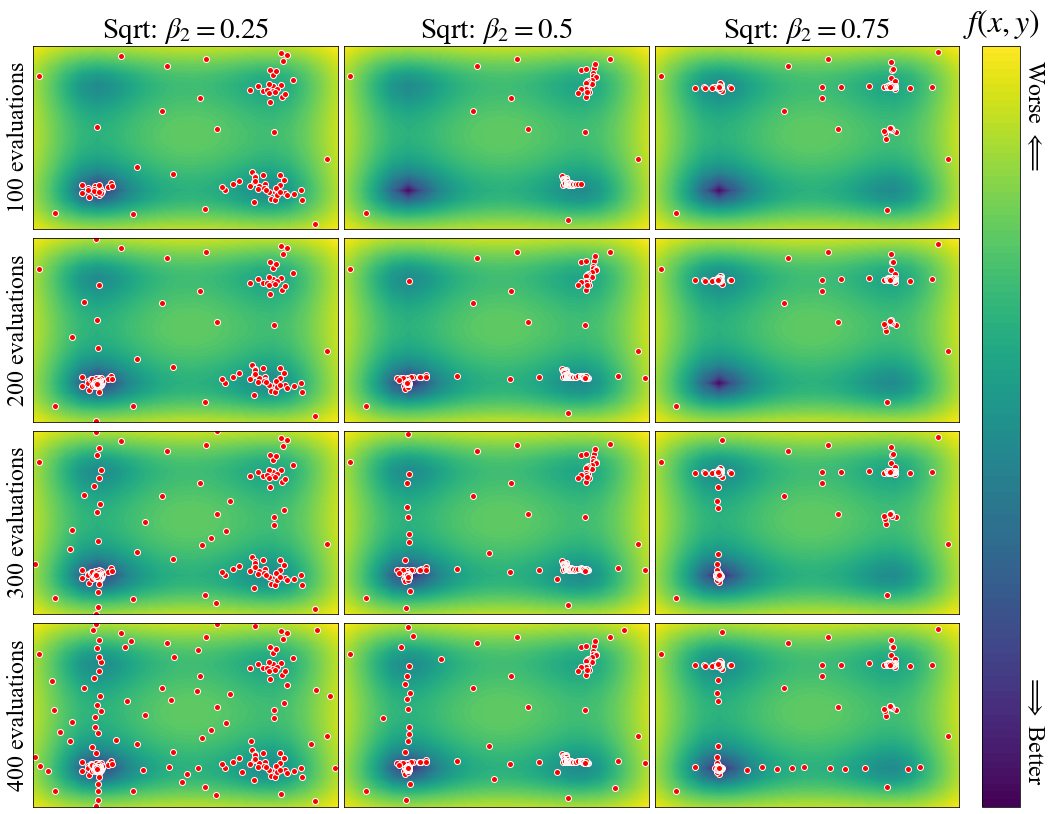

In [17]:
target = Styblinski
X, Y = np.meshgrid(np.linspace(-1, 1, 20), np.linspace(-1, 1, 20))
Z = target.func2d(X, Y)
Z -= Z.min() - 1
Z = np.log(Z)
R = 5
n_levels = 100
levels = np.linspace(Z.min(), Z.max(), n_levels)

max_evals = 400


def add_colorbar(fig, cb, axes):
    cbar = fig.colorbar(cb, ax=axes.ravel().tolist(), pad=0.02)
    cbar.ax.set_title("$f(x, y)$", y=1.01, fontsize=32)
    labels = [""] * n_levels
    labels[-10], labels[10] = "Worse $\Longleftarrow$", "$\Longrightarrow$ Better"
    cbar.set_ticks(levels)
    cbar.set_ticklabels(labels, fontsize=24)
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=270, va="center")
    # tick目盛りを削除
    cbar.ax.tick_params(size=0)
    return cb


def plot_func(ax):
    ax.tick_params(labelbottom=False, bottom=False, labelleft=False, left=False)
    cb = ax.contourf(X * R, Y * R, Z, levels=levels)
    return cb

nrows = 4
fig, axes = plt.subplots(
    ncols=3,
    nrows=nrows,
    figsize=(20, 3.5 * nrows),
    gridspec_kw=dict(
        wspace=0.02,
        hspace=0.05
    )
)
config_space = CS.ConfigurationSpace()
config_space.add_hyperparameter(CS.UniformFloatHyperparameter("x", -1, 1))
config_space.add_hyperparameter(CS.UniformFloatHyperparameter("y", -1, 1))
opt_25 = TPEOptimizer(
    obj_func=target.func,
    config_space=config_space,
    quantile_func=QuantileFunc(choice="sqrt", alpha=0.25),
    max_evals=max_evals,
    min_bandwidth_factor=1e-2,
    weight_func_choice="uniform",
    seed=0,
)
opt_25.optimize()

opt_50 = TPEOptimizer(
    obj_func=target.func,
    config_space=config_space,
    quantile_func=QuantileFunc(choice="sqrt", alpha=0.50),
    max_evals=max_evals,
    min_bandwidth_factor=1e-2,
    weight_func_choice="uniform",
    seed=0,
)
opt_50.optimize()
opt_75 = TPEOptimizer(
    obj_func=target.func,
    config_space=config_space,
    quantile_func=QuantileFunc(choice="sqrt", alpha=0.75),
    max_evals=max_evals,
    min_bandwidth_factor=1e-2,
    weight_func_choice="uniform",
    seed=0,
)
opt_75.optimize()

for r in range(nrows):
    n_evals = 100 * (r + 1)
    ax = axes[r][0]
    if r == 0:
        ax.set_title(f"Sqrt: $\\beta_2 = 0.25$")

    plot_func(ax)
    results_25 = opt_25.fetch_observations()
    ax.scatter(results_25["x"][:n_evals] * R, results_25["y"][:n_evals] * R, color="red", ec="white")
    ax.set_ylabel(f"{n_evals} evaluations")

    ax = axes[r][1]
    if r == 0:
        ax.set_title(f"Sqrt: $\\beta_2 = 0.5$")

    plot_func(ax)
    results_50 = opt_50.fetch_observations()
    ax.scatter(results_50["x"][:n_evals] * R, results_50["y"][:n_evals] * R, color="red", ec="white")

    ax = axes[r][2]
    if r == 0:
        ax.set_title(f"Sqrt: $\\beta_2 = 0.75$")
    cb = plot_func(ax)
    results_75 = opt_75.fetch_observations()
    ax.scatter(results_75["x"][:n_evals] * R, results_75["y"][:n_evals] * R, color="red", ec="white")
else:
    add_colorbar(fig, cb, axes)

plt.savefig("figs/gamma-sqrt-ablation-in-styblinski.pdf", bbox_inches="tight")